In [ ]:
# This file implements a LTSM model to predict taxi demand for a given zone and time in Porto


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import ast


In [2]:
# Load dataset
df = pd.read_csv("taxi_trajectories/cleaned_taxi_data.csv") 


In [3]:
# Only sample 200000 rows
df = df.sample(n=200000, random_state=1234)

In [4]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE,HOUR,DAY_OF_WEEK,MONTH,TRAJECTORY_LENGTH
1335278,1399476189620000031,0,0.0,20000031,2014-05-07 15:23:09,0,"[[-8.631648, 41.15889], [-8.63181, 41.159079],...",15,NaN,5,49
568182,1383824959620000018,0,0.0,20000018,2013-11-07 11:49:19,0,"[[-8.610075, 41.152941], [-8.609967, 41.152824...",11,NaN,11,45
93529,1374414533620000393,1,15.0,20000393,2013-07-21 13:48:53,0,"[[-8.585586, 41.14845], [-8.585811, 41.148792]...",13,NaN,7,44
1266195,1398243456620000343,1,21.0,20000343,2014-04-23 08:57:36,0,"[[-8.628759, 41.160987], [-8.628678, 41.160942...",8,NaN,4,37
1334937,1399477781620000160,1,15.0,20000160,2014-05-07 15:49:41,0,"[[-8.585667, 41.148477], [-8.585658, 41.148495...",15,NaN,5,63


In [18]:
def create_zones(df, n_clusters=10):
    # Convert POLYLINE string to list of coordinates and get first point (pickup location)
    def extract_first_point(polyline_str):
        try:
            coords = ast.literal_eval(polyline_str)  # Convert string to list
            return coords[0] if coords else [np.nan, np.nan]  # Handle empty lists
        except:
            return [np.nan, np.nan]  # Handle invalid formats
    
    # Extract pickup coordinates and keep original index
    pickup_coords = df['POLYLINE'].apply(extract_first_point)
    pickup_df = pd.DataFrame(pickup_coords.tolist(), columns=['pickup_lat', 'pickup_lon'], index=df.index)  # Retain df's original index

    # Identify valid rows (before dropping NaN)
    valid_indices = pickup_df.dropna().index

    # Remove invalid coordinates (without resetting index)
    valid_coords = pickup_df.dropna()

    # Ensure there is enough data to cluster
    if len(valid_coords) < n_clusters:
        raise ValueError("Not enough valid pickup points for clustering!")

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit(valid_coords)

    # Initialize 'zone' column with -1 (instead of None)
    df['zone'] = -1  

    # Assign cluster labels using correct indices
    df.loc[valid_indices, 'zone'] = clusters.labels_

    return df, kmeans


In [6]:
def group_data_by_zone_and_datetime(df):
    # Group by datetime hour and zone to get demand count
    hourly_zone_demand = df.groupby([
        pd.Grouper(key='TIMESTAMP', freq='H'),
        'zone'
    ]).size().reset_index()
    hourly_zone_demand.columns = ['TIMESTAMP', 'zone', 'demand']
    
    # Pivot table to get demand for each zone in columns
    demand_matrix = hourly_zone_demand.pivot(
        index='TIMESTAMP',
        columns='zone',
        values='demand'
    ).fillna(0)

        # Ensure the index is sorted for time series consistency
    demand_matrix = demand_matrix.sort_index()
    
    return demand_matrix

In [7]:
# this function generated via claude.ai
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:(i + seq_length)])
        targets.append(data[i + seq_length])
    
    return np.array(sequences), np.array(targets)

In [24]:
def build_lstm_model(seq_length, n_zones):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, input_shape=(seq_length, n_zones), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(n_zones, activation='relu')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [20]:
n_clusters=10
seq_length=24
test_size=0.2
epochs=50


# Create zones
df_with_zones, kmeans = create_zones(df, n_clusters)
    

Original df index range: 8 1593006
pickup_df index range: 8 1593006
valid_indices (from dropna): [1335278, 568182, 93529, 1266195, 1334937, 783418, 702584, 1426032, 677458, 1027855]


In [21]:
# Group data by zone and datetime
df_with_zones['TIMESTAMP'] = pd.to_datetime(df_with_zones['TIMESTAMP'])
demand_matrix = group_data_by_zone_and_datetime(df_with_zones)
print(demand_matrix.shape)


(8756, 10)


/var/folders/mv/1l8hsgqn1gg1ysw_5rvfsz7c0000gp/T/ipykernel_31373/3966907664.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.Grouper(key='TIMESTAMP', freq='H'),


In [22]:
# Scale the demand data for each zone
scaler = MinMaxScaler()
scaled_demand = scaler.fit_transform(demand_matrix)
    
# Create sequences
X, y = create_sequences(scaled_demand, seq_length)
print(X.shape, y.shape)

(8732, 24, 10) (8732, 10)


In [26]:

    
    # Split data
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
)
    
# Build and train model
model = build_lstm_model(seq_length, n_clusters)
    
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)
    

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0131 - mae: 0.0684 - val_loss: 0.0082 - val_mae: 0.0535
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0080 - mae: 0.0543 - val_loss: 0.0075 - val_mae: 0.0521
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0075 - mae: 0.0531 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0074 - mae: 0.0525 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0072 - mae: 0.0520 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0071 - mae: 0.0511 - val_loss: 0.0069 - val_mae: 0.0503
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0069 - mae: 0.0509 - val_loss: 0.0069 - val_mae: 0.0504
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0070 - mae: 0.0512 - val_loss: 0.0068 - val_mae: 0.0498
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


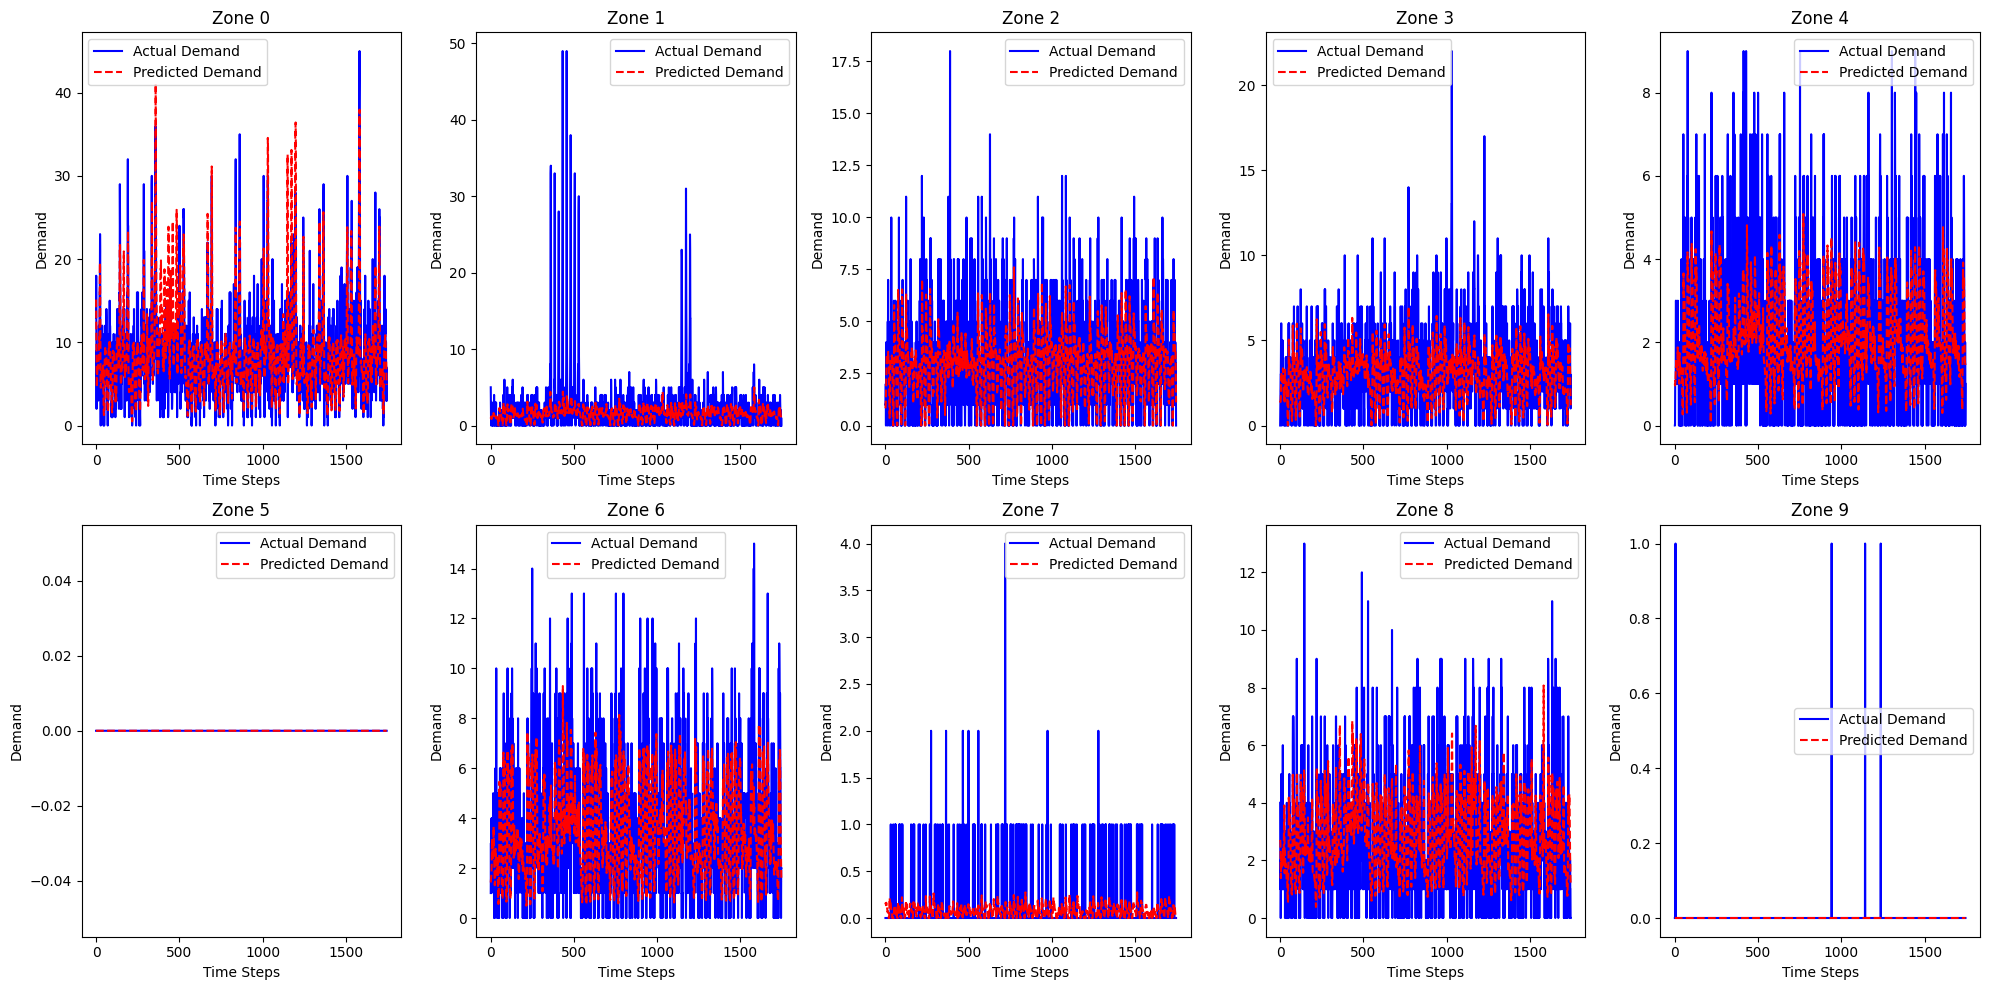

In [29]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the actual and predicted values (if they are scaled)
y_test_actual = scaler.inverse_transform(y_test)  # Actual demand (inverse scaled)
y_pred_actual = scaler.inverse_transform(y_pred)  # Predicted demand (inverse scaled)

# Create a figure with 10 subplots (2 rows and 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Adjust figure size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot actual vs predicted for all 10 zones
for zone_index in range(10):
    axes[zone_index].plot(y_test_actual[:, zone_index], label='Actual Demand', color='blue')
    axes[zone_index].plot(y_pred_actual[:, zone_index], label='Predicted Demand', color='red', linestyle='--')
    axes[zone_index].set_title(f'Zone {zone_index}')
    axes[zone_index].set_xlabel('Time Steps')
    axes[zone_index].set_ylabel('Demand')
    axes[zone_index].legend()

# Adjust the layout
plt.tight_layout()
plt.show()